<a href="https://colab.research.google.com/github/DarshanaRamroop/python_project/blob/master/animeprediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from scipy.sparse import hstack
import csv
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap


#load dataset
animes_df = pd.read_csv('/content/animes.csv')
profiles_df = pd.read_csv('/content/profiles.csv')
reviews_df = pd.read_csv('/content/reviews.csv', quoting=csv.QUOTE_NONE, on_bad_lines='skip', encoding='utf-8', engine='python')


#check for missing values
print("\n Missing Values in animes.csv \n",animes_df.isnull().sum())
print("\n Missing Values in profiles.csv \n ",profiles_df.isnull().sum())
print("\n Missing Values in reviews_df \n",reviews_df.isnull().sum())

#handle missing values
animes_df['synopsis'] = animes_df['synopsis'].fillna('')
animes_df['episodes'] = animes_df['episodes'].fillna(-1)
animes_df['ranked'] = animes_df['ranked'].fillna(animes_df['ranked'].max() + 1)
animes_df['score'] = animes_df['score'].fillna(animes_df['score'].median())
animes_df['img_url'] = animes_df['img_url'].fillna('https://placeholder.com/image.jpg')

profiles_df['gender'] = profiles_df['gender'].fillna('Unknown')
profiles_df['birthday'] = profiles_df['birthday'].fillna('Unknown')

#clean and convert anime_uid in reviews
reviews_df = reviews_df[pd.to_numeric(reviews_df['anime_uid'], errors='coerce').notnull()]
reviews_df.loc[:, 'anime_uid'] = reviews_df['anime_uid'].astype(float).astype(int)

#merge profiles.csv with reviews.csv
reviews_df = reviews_df.merge(profiles_df, how='left', left_on='profile', right_on='profile')

#merge reviews.csv with animes.csv
merged_df = reviews_df.merge(animes_df, left_on='anime_uid', right_on='uid', how='left')

print(merged_df)
print("Shape of merged dataset:", merged_df.shape)

#target variable
merged_df['high_rating'] = (merged_df['score_y'] >= 8.0).astype(int)

#feature selection
features = merged_df[['synopsis', 'genre', 'episodes', 'members', 'popularity']].copy()
features['synopsis'] = features['synopsis'].fillna('')
target = merged_df['high_rating']

#TF-IDF vectorizer for synopsis
tfidf = TfidfVectorizer(max_features=100)
synopsis_tfidf = tfidf.fit_transform(features['synopsis'])

#one-hot encode genre
genre_df = features['genre'].fillna('[]').apply(eval)
genre_df = genre_df.apply(lambda x: [g.strip() for g in x])
all_genres = sorted(set(g for sublist in genre_df for g in sublist))
genre_encoded = pd.DataFrame(0, index=genre_df.index, columns=all_genres)
for i, genres in genre_df.items():
    for g in genres:
        genre_encoded.at[i, g] = 1

#combine the features
numeric_features = features[['episodes', 'members', 'popularity']].fillna(0)
X = hstack([synopsis_tfidf, genre_encoded.to_numpy(), numeric_features])
y = merged_df['high_rating']



#stratified K-Fold splitter
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scorer_accuracy = make_scorer(accuracy_score)
scorer_precision = make_scorer(precision_score)
scorer_recall = make_scorer(recall_score)
scorer_f1 = make_scorer(f1_score)

#logistic regression

lr_model = LogisticRegression(max_iter=1000,random_state=42)

lr_accuracy_scores = cross_val_score(lr_model, X, y, cv=skf, scoring=scorer_accuracy)
lr_precision_scores = cross_val_score(lr_model, X, y, cv=skf, scoring=scorer_precision)
lr_recall_scores = cross_val_score(lr_model, X, y, cv=skf, scoring=scorer_recall)
lr_f1_scores = cross_val_score(lr_model, X, y, cv=skf, scoring=scorer_f1)

print("\nLogistic Regression ")
print(f"Average Accuracy: {np.mean(lr_accuracy_scores):.4f} (Std: {np.std(lr_accuracy_scores):.4f})")
print(f"Average Precision: {np.mean(lr_precision_scores):.4f} (Std: {np.std(lr_precision_scores):.4f})")
print(f"Average Recall: {np.mean(lr_recall_scores):.4f} (Std: {np.std(lr_recall_scores):.4f})")
print(f"Average F1-Score: {np.mean(lr_f1_scores):.4f} (Std: {np.std(lr_f1_scores):.4f})")

#predictions
y_pred_lr_cv = cross_val_predict(lr_model, X, y, cv=skf)




 Missing Values in animes.csv 
 uid              0
title            0
synopsis       975
genre            0
aired            0
episodes       706
members          0
popularity       0
ranked        3212
score          579
img_url        180
link             0
dtype: int64

 Missing Values in profiles.csv 
  profile                0
gender             27871
birthday           34920
favorites_anime        0
link                   0
dtype: int64

 Missing Values in reviews_df 
 uid              1
profile      66149
anime_uid    71662
text         75942
score        82998
scores       85458
link         87292
dtype: int64
        uid_x         profile anime_uid  text score_x scores link_x   gender  \
0      255938  DesolatePsyche     34096     "    None   None   None     Male   
1      255938  DesolatePsyche     34096     "    None   None   None     Male   
2      255938  DesolatePsyche     34096     "    None   None   None     Male   
3      255938  DesolatePsyche     34096     "    None

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c


Logistic Regression 
Average Accuracy: 0.9988 (Std: 0.0003)
Average Precision: 1.0000 (Std: 0.0000)
Average Recall: 0.9752 (Std: 0.0061)
Average F1-Score: 0.9874 (Std: 0.0031)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

/tmp/ipython-input-3-2281667711.py:36: UserWarning: Glyph 128315 (\N{DOWN-POINTING RED TRIANGLE}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipython-input-3-2281667711.py:36: UserWarning: Glyph 128314 (\N{UP-POINTING RED TRIANGLE}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128315 (\N{DOWN-POINTING RED TRIANGLE}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128314 (\N{UP-POINTING RED TRIANGLE}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


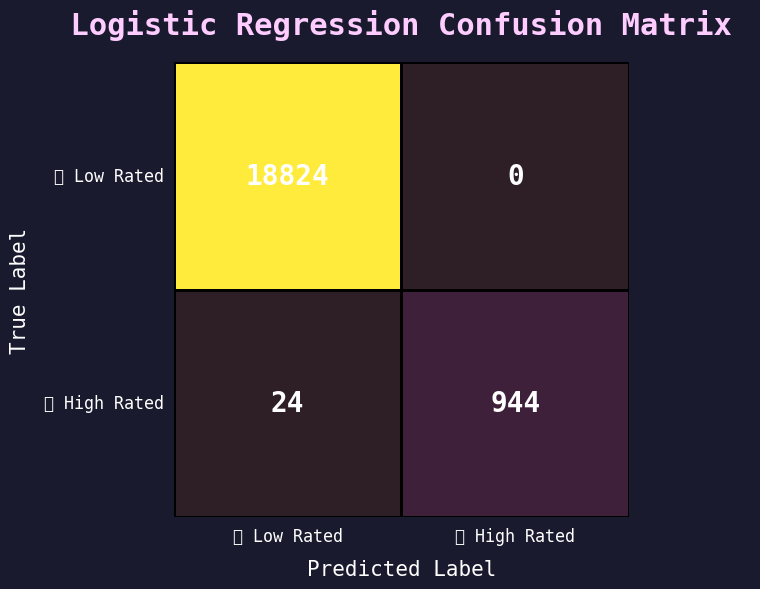

/tmp/ipython-input-3-2281667711.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


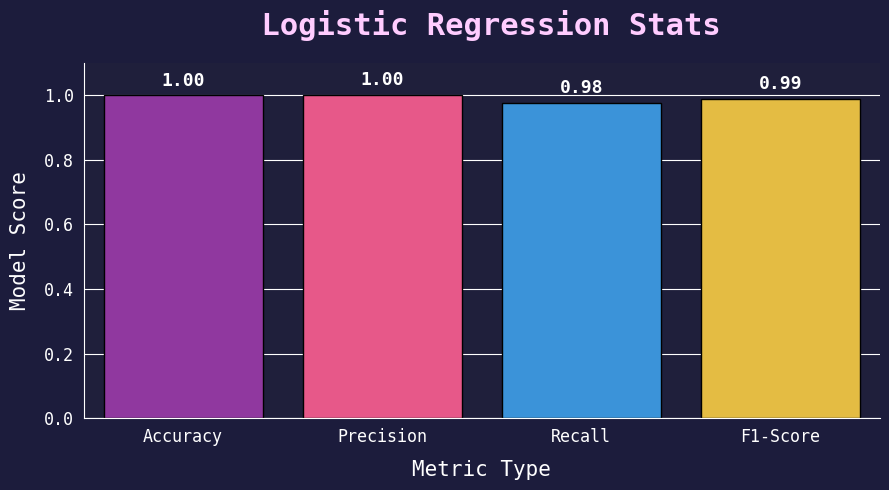

In [ ]:
#visualization
# Confusion Matrix Heatmap
anime_cmap = LinearSegmentedColormap.from_list("anime_cmap", ["#2e1f27", "#9c27b0", "#e91e63", "#ffeb3b"])
cm_lr_cv = confusion_matrix(y, y_pred_lr_cv)

plt.figure(figsize=(7.5, 6))
sns.set_style("darkgrid")

rcParams['font.family'] = ['monospace']
rcParams['axes.titlesize'] = 22
rcParams['axes.titleweight'] = 'bold'
rcParams['axes.labelsize'] = 14
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
rcParams['figure.facecolor'] = '#1c1c3c'
rcParams['axes.facecolor'] = '#252547'

sns.heatmap(
    cm_lr_cv,
    annot=True,
    fmt='d',
    cmap=anime_cmap,
    cbar=False,
    linewidths=2,
    linecolor='black',
    square=True,
    annot_kws={"size": 20, "weight": "bold", "color": "#ffffff"}
)

plt.title(" Logistic Regression Confusion Matrix ", fontsize=22, color='#ffccff', pad=20)
plt.xlabel("Predicted Label", fontsize=15, labelpad=10, color='white')
plt.ylabel("True Label", fontsize=15, labelpad=10, color='white')
plt.xticks(ticks=[0.5, 1.5], labels=['🔻 Low Rated', '🔺 High Rated'], rotation=0, color='white')
plt.yticks(ticks=[0.5, 1.5], labels=['🔻 Low Rated', '🔺 High Rated'], rotation=0, color='white')
plt.grid(visible=False)
plt.tight_layout()
plt.show()

# Performance Metrics Bar Plot
metrics_lr_cv = {
    'Accuracy': np.mean(lr_accuracy_scores),
    'Precision': np.mean(lr_precision_scores),
    'Recall': np.mean(lr_recall_scores),
    'F1-Score': np.mean(lr_f1_scores)
}
anime_palette = ["#9c27b0", "#ff4081", "#2196f3", "#ffca28"]

plt.figure(figsize=(9, 5))
sns.set_style("darkgrid")
rcParams['font.family'] = ['monospace']
rcParams['axes.titlesize'] = 22
rcParams['axes.titleweight'] = 'bold'
rcParams['axes.labelsize'] = 15
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
rcParams['figure.facecolor'] = '#1a1a2e'
rcParams['axes.facecolor'] = '#1f1f3b'


sns.barplot(
    x=list(metrics_lr_cv.keys()),
    y=list(metrics_lr_cv.values()),
    palette=anime_palette,
    edgecolor='black'
)

plt.ylim(0, 1.1)
plt.title(" Logistic Regression Stats", color="#ffccff", pad=20)
plt.ylabel("Model Score", fontsize=15, labelpad=10, color="white")
plt.xlabel("Metric Type", fontsize=15, labelpad=10, color="white")

for i, v in enumerate(metrics_lr_cv.values()):
    plt.text(i, v + 0.03, f"{v:.2f}", ha='center', fontsize=13, weight='bold', color='white')

plt.xticks(color='white')
plt.yticks(color='white')
sns.despine()
plt.tight_layout()
plt.show()


Decision Tree
Average Accuracy: 1.0000 (Std: 0.0000)
Average Precision: 1.0000 (Std: 0.0000)
Average Recall: 1.0000 (Std: 0.0000)
Average F1-Score: 1.0000 (Std: 0.0000)


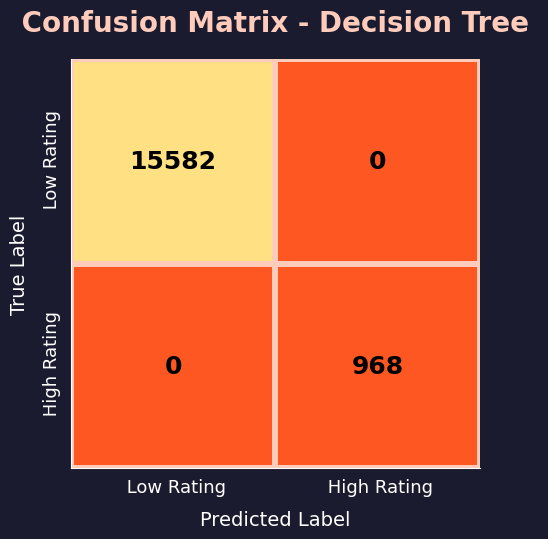

In [ ]:
#decision tree
dt_model = DecisionTreeClassifier(random_state=42)

dt_accuracy_scores = cross_val_score(dt_model, X, y, cv=skf, scoring=scorer_accuracy)
dt_precision_scores = cross_val_score(dt_model, X, y, cv=skf, scoring=scorer_precision)
dt_recall_scores = cross_val_score(dt_model, X, y, cv=skf, scoring=scorer_recall)
dt_f1_scores = cross_val_score(dt_model, X, y, cv=skf, scoring=scorer_f1)

print("\nDecision Tree")
print(f"Average Accuracy: {np.mean(dt_accuracy_scores):.4f} (Std: {np.std(dt_accuracy_scores):.4f})")
print(f"Average Precision: {np.mean(dt_precision_scores):.4f} (Std: {np.std(dt_precision_scores):.4f})")
print(f"Average Recall: {np.mean(dt_recall_scores):.4f} (Std: {np.std(dt_recall_scores):.4f})")
print(f"Average F1-Score: {np.mean(dt_f1_scores):.4f} (Std: {np.std(dt_f1_scores):.4f})")

#prediction
y_pred_dt_cv = cross_val_predict(dt_model, X, y, cv=skf)

#visualization
cm_dt_cv = confusion_matrix(y, y_pred_dt_cv)
rcParams['font.family'] = ['monospace']
rcParams['figure.facecolor'] = '#1b1b2f'
rcParams['axes.facecolor'] = '#1b1b2f'
rcParams['axes.titleweight'] = 'bold'
plt.figure(figsize=(6.5, 5.5))
sns.set_style("dark")

sns.heatmap(
    cm_dt_cv,
    annot=True,
    fmt='d',
    cmap=sns.color_palette(["#ff5722", "#ff7043", "#ffa726", "#ffe082"], as_cmap=True),
    cbar=False,
    linewidths=3,
    linecolor='#ffccbc',
    square=True,
    annot_kws={"size": 18, "weight": "bold", "color": "black"}
)

plt.title(' Confusion Matrix - Decision Tree ', fontsize=20, color="#ffccbc", pad=20)
plt.xlabel('Predicted Label', fontsize=14, color='white', labelpad=10)
plt.ylabel('True Label', fontsize=14, color='white', labelpad=10)

plt.xticks([0.5, 1.5], [' Low Rating', ' High Rating'], fontsize=13, color='white')
plt.yticks([0.5, 1.5], [' Low Rating', ' High Rating'], fontsize=13, color='white')

sns.despine()
plt.tight_layout()
plt.show()



/tmp/ipython-input-4-1909108691.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(


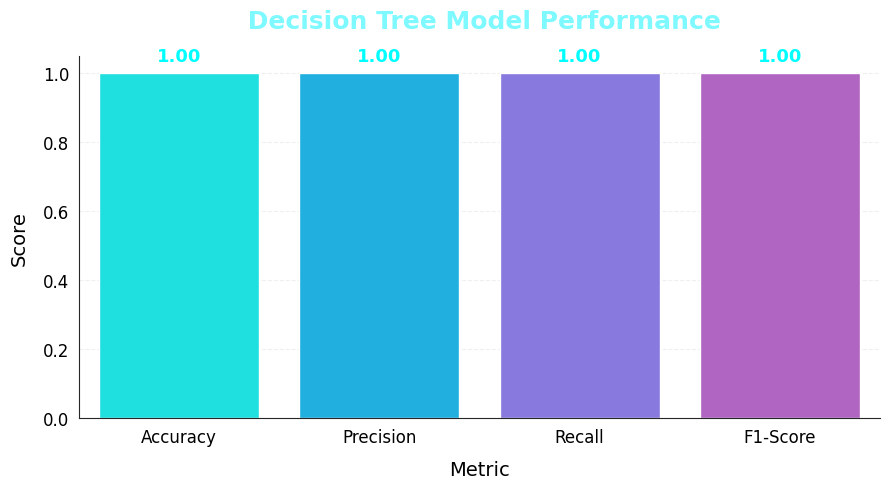

In [ ]:
# Decision Tree Performance Metrics Bar Plot
rcParams['font.family'] = ['monospace']
rcParams['figure.facecolor'] = '#0d0f1e'
sns.set_style("white")
neon_palette = ["#00FFFF", "#00BFFF", "#7B68EE", "#BA55D3"]

metrics_dt_cv = {
    'Accuracy': np.mean(dt_accuracy_scores),
    'Precision': np.mean(dt_precision_scores),
    'Recall': np.mean(dt_recall_scores),
    'F1-Score': np.mean(dt_f1_scores)
}

plt.figure(figsize=(9, 5))
bars = sns.barplot(
    x=list(metrics_dt_cv.keys()),
    y=list(metrics_dt_cv.values()),
    palette=neon_palette,
    edgecolor='white'
)

for i, v in enumerate(metrics_dt_cv.values()):
    plt.text(i, v + 0.035, f"{v:.2f}", ha='center', fontsize=13, color='cyan', weight='bold')


plt.title(' Decision Tree Model Performance', fontsize=18, color='#7DF9FF', pad=20)
plt.xlabel('Metric', fontsize=14, color='black', labelpad=10)
plt.ylabel('Score', fontsize=14, color='black', labelpad=10)
plt.xticks(color='black', fontsize=12)
plt.yticks(color='black', fontsize=12)
plt.ylim(0, 1.05)

sns.despine()
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


SVM
Average Accuracy: 0.9590 (Std: 0.0026)
Average Precision: 1.0000 (Std: 0.0000)
Average Recall: 0.2996 (Std: 0.0438)
Average F1-Score: 0.4593 (Std: 0.0511)


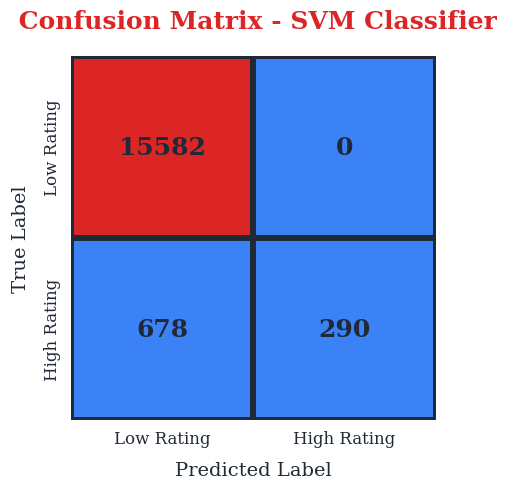

/tmp/ipython-input-28-3776991871.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(


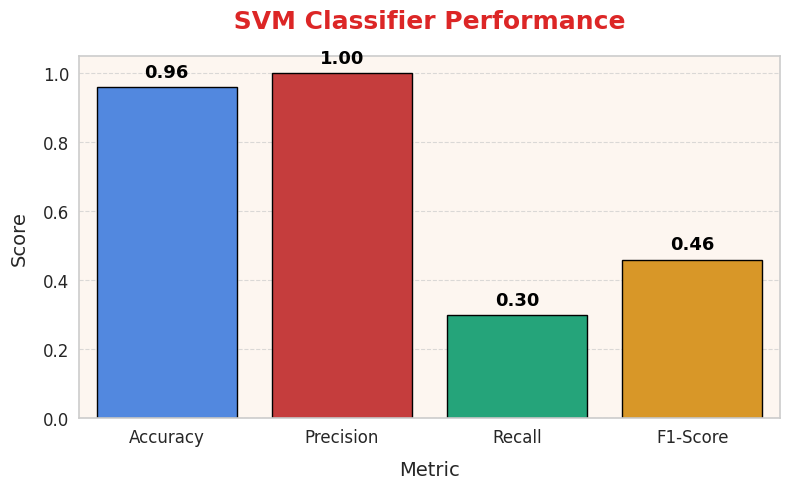

In [ ]:
#svm
svm_model = SVC(random_state=42)
svm_accuracy_scores = cross_val_score(svm_model, X, y, cv=skf, scoring=scorer_accuracy)
svm_precision_scores = cross_val_score(svm_model, X, y, cv=skf, scoring=scorer_precision)
svm_recall_scores = cross_val_score(svm_model, X, y, cv=skf, scoring=scorer_recall)
svm_f1_scores = cross_val_score(svm_model, X, y, cv=skf, scoring=scorer_f1)

print("\nSVM")
print(f"Average Accuracy: {np.mean(svm_accuracy_scores):.4f} (Std: {np.std(svm_accuracy_scores):.4f})")
print(f"Average Precision: {np.mean(svm_precision_scores):.4f} (Std: {np.std(svm_precision_scores):.4f})")
print(f"Average Recall: {np.mean(svm_recall_scores):.4f} (Std: {np.std(svm_recall_scores):.4f})")
print(f"Average F1-Score: {np.mean(svm_f1_scores):.4f} (Std: {np.std(svm_f1_scores):.4f})")

#make prediction
y_pred_svm_cv = cross_val_predict(svm_model, X, y, cv=skf)

#visualization
rcParams['font.family'] = ['serif']
cm_svm_cv = confusion_matrix(y, y_pred_svm_cv)

wave_blue = "#3B82F6"
sunset_red = "#DC2626"
paper_bg = "#F5F3F0"
ink_black = "#1F2937"

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_svm_cv,
    annot=True,
    fmt='d',
    cmap=sns.color_palette([wave_blue, sunset_red], as_cmap=True),
    cbar=False,
    linewidths=3,
    linecolor=ink_black,
    square=True,
    annot_kws={"size": 18, "weight": "bold", "color": ink_black}
)

plt.title(" Confusion Matrix - SVM Classifier", fontsize=18, color=sunset_red, pad=20, weight='bold')
plt.xlabel("Predicted Label", fontsize=14, color=ink_black, labelpad=10)
plt.ylabel("True Label", fontsize=14, color=ink_black, labelpad=10)


plt.xticks([0.5, 1.5], ['Low Rating', 'High Rating'], fontsize=12, color=ink_black)
plt.yticks([0.5, 1.5], ['Low Rating', 'High Rating'], fontsize=12, color=ink_black)
plt.gca().set_facecolor(paper_bg)
plt.tight_layout()
plt.show()

# Visualization - Performance Metrics Bar Plot
rcParams['font.family'] = 'serif'
sns.set_style("whitegrid")
metrics_colors = ['#3B82F6', '#DC2626', '#10B981', '#F59E0B']

metrics_svm_cv = {
    'Accuracy': np.mean(svm_accuracy_scores),
    'Precision': np.mean(svm_precision_scores),
    'Recall': np.mean(svm_recall_scores),
    'F1-Score': np.mean(svm_f1_scores)
}

plt.figure(figsize=(8, 5))
bars = sns.barplot(
    x=list(metrics_svm_cv.keys()),
    y=list(metrics_svm_cv.values()),
    palette=metrics_colors,
    edgecolor='black'
)


for i, v in enumerate(metrics_svm_cv.values()):
    plt.text(i, v + 0.03, f"{v:.2f}", ha='center', fontsize=13, fontweight='bold', color='black')

plt.ylim(0, 1.05)
plt.title(' SVM Classifier Performance ', fontsize=18, color='#DC2626', pad=20)
plt.ylabel('Score', fontsize=14, labelpad=10)
plt.xlabel('Metric', fontsize=14, labelpad=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().set_facecolor('#FDF6F0')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Random Forest
Average Accuracy: 1.0000 (Std: 0.0000)
Average Precision: 1.0000 (Std: 0.0000)
Average Recall: 1.0000 (Std: 0.0000)
Average F1-Score: 1.0000 (Std: 0.0000)


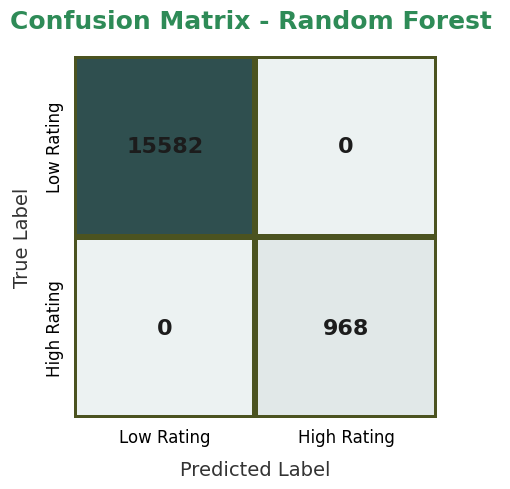

/tmp/ipython-input-7-510432521.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


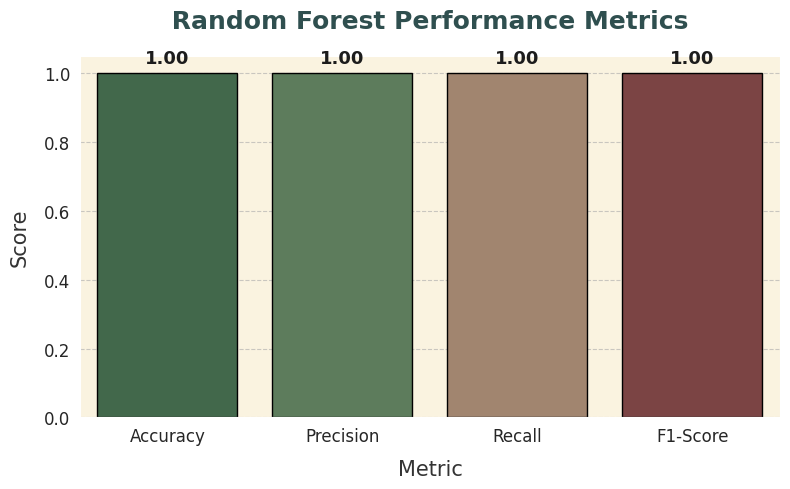

In [ ]:
#random forest
rf_model = RandomForestClassifier(random_state=42)

rf_accuracy_scores = cross_val_score(rf_model, X, y, cv=skf, scoring=scorer_accuracy)
rf_precision_scores = cross_val_score(rf_model, X, y, cv=skf, scoring=scorer_precision)
rf_recall_scores = cross_val_score(rf_model, X, y, cv=skf, scoring=scorer_recall)
rf_f1_scores = cross_val_score(rf_model, X, y, cv=skf, scoring=scorer_f1)

print("\nRandom Forest")
print(f"Average Accuracy: {np.mean(rf_accuracy_scores):.4f} (Std: {np.std(rf_accuracy_scores):.4f})")
print(f"Average Precision: {np.mean(rf_precision_scores):.4f} (Std: {np.std(rf_precision_scores):.4f})")
print(f"Average Recall: {np.mean(rf_recall_scores):.4f} (Std: {np.std(rf_recall_scores):.4f})")
print(f"Average F1-Score: {np.mean(rf_f1_scores):.4f} (Std: {np.std(rf_f1_scores):.4f})")

#make prediction
y_pred_rf_cv = cross_val_predict(rf_model, X, y, cv=skf)

#visualisation
cm_rf_cv = confusion_matrix(y, y_pred_rf_cv)
rcParams['font.family'] = 'serif'
sns.set_style("darkgrid")
aot_cmap = sns.light_palette("#2F4F4F", as_cmap=True)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_rf_cv,
    annot=True,
    fmt='d',
    cmap=aot_cmap,
    cbar=False,
    linewidths=3,
    linecolor='#4B5320',
    square=True,
    annot_kws={"size": 16, "weight": "bold", "color": "#1C1C1C"}
)

plt.title('Confusion Matrix - Random Forest ', fontsize=18, color='#2E8B57', pad=20)
plt.xlabel('Predicted Label', fontsize=14, labelpad=10, color='#333333')
plt.ylabel('True Label', fontsize=14, labelpad=10, color='#333333')
plt.xticks([0.5, 1.5], ['Low Rating', 'High Rating'], fontsize=12, color='black')
plt.yticks([0.5, 1.5], ['Low Rating', 'High Rating'], fontsize=12, color='black')
plt.gca().set_facecolor('#F5F5DC')
plt.tight_layout()
plt.show()

#visualization
metrics_rf_cv = {
    'Accuracy': np.mean(rf_accuracy_scores),
    'Precision': np.mean(rf_precision_scores),
    'Recall': np.mean(rf_recall_scores),
    'F1-Score': np.mean(rf_f1_scores)
}

rcParams['font.family'] = 'serif'
sns.set_style("darkgrid")

aot_colors = ['#3C6E47', '#588157', '#A98467', '#843B3B']
plt.figure(figsize=(8, 5))
sns.barplot(
    x=list(metrics_rf_cv.keys()),
    y=list(metrics_rf_cv.values()),
    palette=aot_colors,
    edgecolor='black'
)

plt.gca().set_facecolor('#FAF3E0')
plt.ylim(0, 1.05)
plt.title(' Random Forest Performance Metrics ', fontsize=18, pad=20, color='#2F4F4F')
plt.ylabel('Score', fontsize=15, labelpad=10, color='#333333')
plt.xlabel('Metric', fontsize=15, labelpad=10, color='#333333')


for i, v in enumerate(metrics_rf_cv.values()):
    plt.text(i, v + 0.03, f"{v:.2f}", ha='center', fontsize=13, weight='bold', color='#1C1C1C')

plt.grid(True, which='major', axis='y', linestyle='--', color='#A9A9A9', alpha=0.6)
plt.tight_layout()
plt.show()


Gradient Boosting
Average Accuracy: 1.0000 (Std: 0.0000)
Average Precision: 1.0000 (Std: 0.0000)
Average Recall: 1.0000 (Std: 0.0000)
Average F1-Score: 1.0000 (Std: 0.0000)


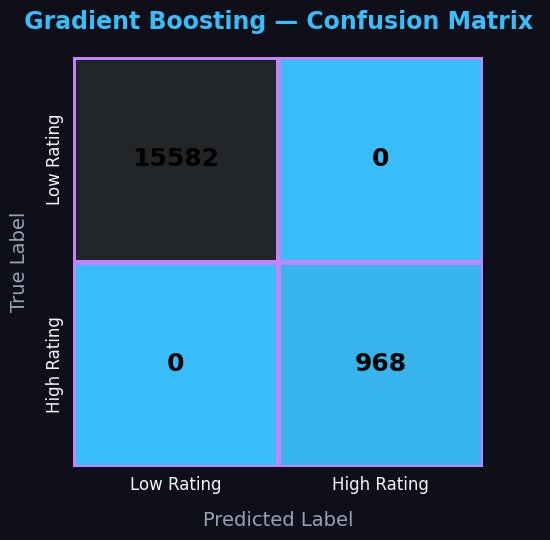

/tmp/ipython-input-11-1836913989.py:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(
/tmp/ipython-input-11-1836913989.py:105: UserWarning: Glyph 128171 (\N{DIZZY SYMBOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128171 (\N{DIZZY SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


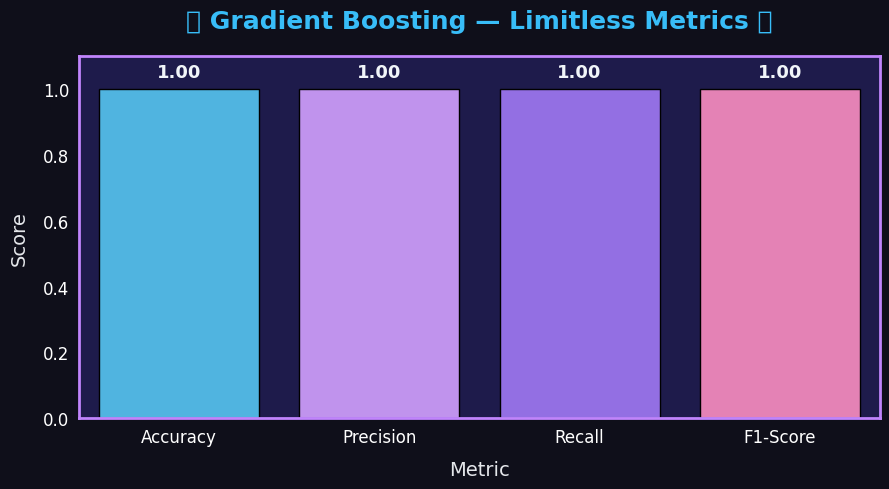

In [ ]:
#gradient boosting
gb_model = GradientBoostingClassifier(random_state=42)

gb_accuracy_scores = cross_val_score(gb_model, X, y, cv=skf, scoring=scorer_accuracy)
gb_precision_scores = cross_val_score(gb_model, X, y, cv=skf, scoring=scorer_precision)
gb_recall_scores = cross_val_score(gb_model, X, y, cv=skf, scoring=scorer_recall)
gb_f1_scores = cross_val_score(gb_model, X, y, cv=skf, scoring=scorer_f1)


print("\nGradient Boosting")
print(f"Average Accuracy: {np.mean(gb_accuracy_scores):.4f} (Std: {np.std(gb_accuracy_scores):.4f})")
print(f"Average Precision: {np.mean(gb_precision_scores):.4f} (Std: {np.std(gb_precision_scores):.4f})")
print(f"Average Recall: {np.mean(gb_recall_scores):.4f} (Std: {np.std(gb_recall_scores):.4f})")
print(f"Average F1-Score: {np.mean(gb_f1_scores):.4f} (Std: {np.std(gb_f1_scores):.4f})")

#make prediction
y_pred_gb_cv = cross_val_predict(gb_model, X, y, cv=skf)

#visualization
cm_gb_cv = confusion_matrix(y, y_pred_gb_cv)
rcParams['font.family'] = 'monospace'
sns.set_style("white")
background_color = '#0F0F1A'
border_color = '#C084FC'
highlight_color = '#38BDF8'
text_color = '#F1F5F9'
label_color = '#94A3B8'

plt.figure(figsize=(6.5, 5.5))
ax = sns.heatmap(
    cm_gb_cv,
    annot=True,
    fmt='d',
    cmap=sns.dark_palette(highlight_color, reverse=True, as_cmap=True),
    cbar=False,
    linewidths=2.5,
    linecolor=border_color,
    square=True,
    annot_kws={"size": 18, "weight": "bold", "color": '#000000'}
)

ax.set_facecolor(background_color)
plt.gcf().set_facecolor(background_color)
plt.title(' Gradient Boosting — Confusion Matrix ', fontsize=17, color=highlight_color, pad=20)
plt.xlabel('Predicted Label', fontsize=14, color=label_color, labelpad=12)
plt.ylabel('True Label', fontsize=14, color=label_color, labelpad=12)
plt.xticks([0.5, 1.5], ['Low Rating', 'High Rating'], fontsize=12, color=text_color)
plt.yticks([0.5, 1.5], ['Low Rating', 'High Rating'], fontsize=12, color=text_color)

for spine in ax.spines.values():
    spine.set_edgecolor(border_color)
    spine.set_linewidth(2)

plt.tight_layout()
plt.show()

# Gradient Boosting Performance Metrics Bar Plot
metrics_gb_cv = {
    'Accuracy': np.mean(gb_accuracy_scores),
    'Precision': np.mean(gb_precision_scores),
    'Recall': np.mean(gb_recall_scores),
    'F1-Score': np.mean(gb_f1_scores)
}

rcParams['font.family'] = 'monospace'
sns.set_style("darkgrid")
colors = ['#38BDF8', '#C084FC', '#8B5CF6', '#F472B6']

plt.figure(figsize=(9, 5))
bars = sns.barplot(
    x=list(metrics_gb_cv.keys()),
    y=list(metrics_gb_cv.values()),
    palette=colors,
    edgecolor='black'
)

for i, v in enumerate(metrics_gb_cv.values()):
    bars.text(i, v + 0.035, f"{v:.2f}", ha='center', fontweight='bold', fontsize=13, color='#F1F5F9')


plt.title("💫 Gradient Boosting — Limitless Metrics 💫", fontsize=18, color='#38BDF8', pad=20)
plt.xlabel("Metric", fontsize=14, labelpad=10, color='#E5E7EB')
plt.ylabel("Score", fontsize=14, labelpad=10, color='#E5E7EB')
plt.ylim(0, 1.1)
plt.xticks(fontsize=12, color='white')
plt.yticks(fontsize=12, color='white')
plt.gcf().patch.set_facecolor('#0F0F1A')
plt.gca().set_facecolor('#1E1B4B')
plt.grid(visible=False)


for spine in plt.gca().spines.values():
    spine.set_edgecolor('#C084FC')
    spine.set_linewidth(2)

plt.tight_layout()
plt.show()

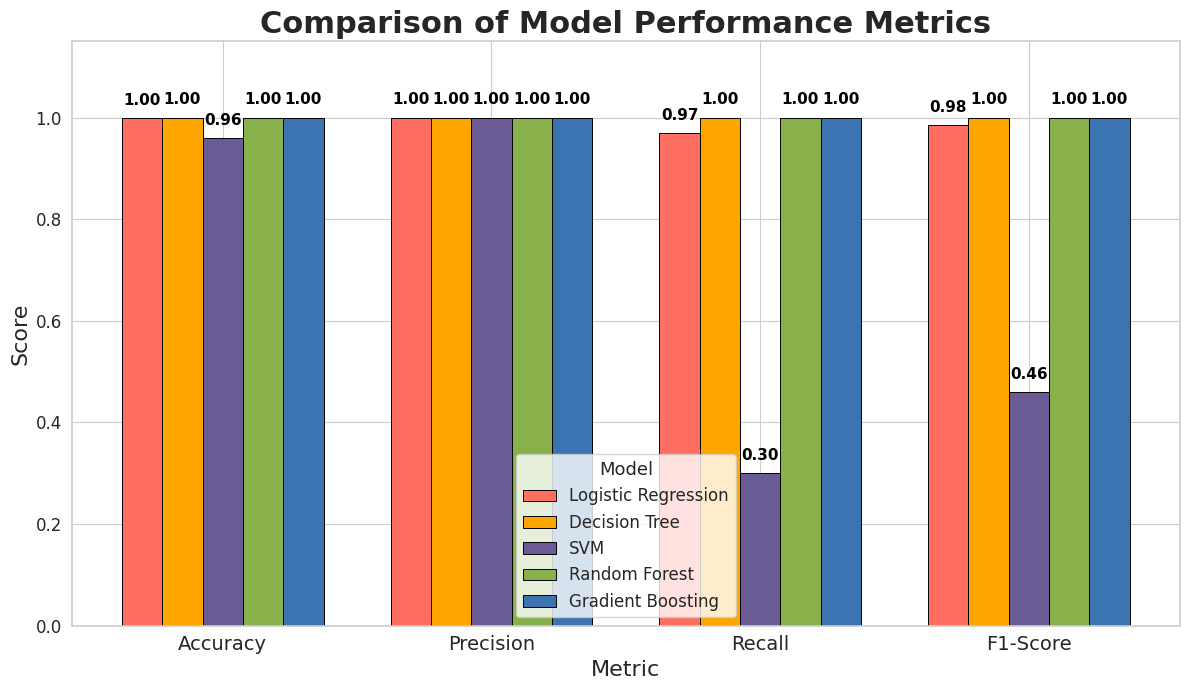

In [ ]:
#comparison of all the model
all_metrics = {
    'Logistic Regression': {
        'Accuracy': np.mean(lr_accuracy_scores),
        'Precision': np.mean(lr_precision_scores),
        'Recall': np.mean(lr_recall_scores),
        'F1-Score': np.mean(lr_f1_scores)
    },
    'Decision Tree': {
        'Accuracy': np.mean(dt_accuracy_scores),
        'Precision': np.mean(dt_precision_scores),
        'Recall': np.mean(dt_recall_scores),
        'F1-Score': np.mean(dt_f1_scores)
    },
    'SVM': {
        'Accuracy': np.mean(svm_accuracy_scores),
        'Precision': np.mean(svm_precision_scores),
        'Recall': np.mean(svm_recall_scores),
        'F1-Score': np.mean(svm_f1_scores)
    },
    'Random Forest': {
        'Accuracy': np.mean(rf_accuracy_scores),
        'Precision': np.mean(rf_precision_scores),
        'Recall': np.mean(rf_recall_scores),
        'F1-Score': np.mean(rf_f1_scores)
    },
    'Gradient Boosting': {
        'Accuracy': np.mean(gb_accuracy_scores),
        'Precision': np.mean(gb_precision_scores),
        'Recall': np.mean(gb_recall_scores),
        'F1-Score': np.mean(gb_f1_scores)
    }
}

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
models = list(all_metrics.keys())


df = pd.DataFrame(all_metrics).T[metrics]


plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")


palette = {
    'Logistic Regression': '#FF6F61',
    'Decision Tree': '#FFA500',
    'SVM': '#6B5B95',
    'Random Forest': '#88B04B',
    'Gradient Boosting': '#3C74B1'
}

bar_width = 0.15
x = np.arange(len(metrics))

for i, model in enumerate(models):
    plt.bar(
        x + i * bar_width,
        df.loc[model],
        width=bar_width,
        label=model,
        color=palette[model],
        edgecolor='black',
        linewidth=0.7
    )

for i, model in enumerate(models):
    for j, metric in enumerate(metrics):
        val = df.loc[model, metric]
        plt.text(
            x[j] + i * bar_width,
            val + 0.02,
            f"{val:.2f}",
            ha='center',
            va='bottom',
            fontsize=11,
            fontweight='bold',
            color='black'
        )

plt.xticks(x + bar_width * (len(models) - 1) / 2, metrics, fontsize=14)
plt.ylim(0, 1.15)
plt.title('Comparison of Model Performance Metrics', fontsize=22, fontweight='bold')
plt.ylabel('Score', fontsize=16)
plt.xlabel('Metric', fontsize=16)
plt.legend(title='Model', fontsize=12, title_fontsize=13)
plt.tight_layout()
plt.show()

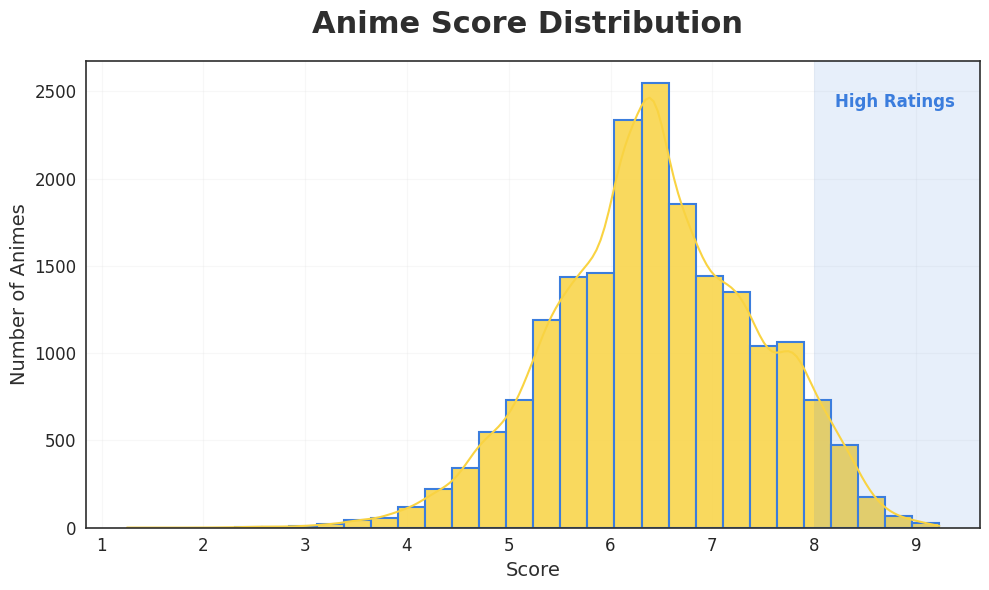

In [ ]:
#additional visualization
from matplotlib.patches import Rectangle
pokemon_palette = {
    'electric_yellow': '#F9D342',
    'dark_gray': '#2E2E2E',
    'light_gray': '#E5E5E5',
    'electric_blue': '#3B7DDD',
    'white': '#FFFFFF'
}

sns.set_style("white")
plt.rcParams.update({
    'axes.titlesize': 22,
    'axes.titleweight': 'bold',
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.edgecolor': pokemon_palette['dark_gray'],
    'axes.linewidth': 1.2,
    'grid.color': pokemon_palette['light_gray'],
    'grid.linewidth': 0.8,
})

plt.figure(figsize=(10,6))

sns.histplot(
    animes_df['score'].dropna(),
    bins=30,
    kde=True,
    color=pokemon_palette['electric_yellow'],
    edgecolor=pokemon_palette['electric_blue'],
    linewidth=1.5,
    alpha=0.85
)

plt.grid(True, linestyle='-', alpha=0.3)
plt.title("Anime Score Distribution ", color=pokemon_palette['dark_gray'], pad=20)
plt.xlabel("Score", color=pokemon_palette['dark_gray'])
plt.ylabel("Number of Animes", color=pokemon_palette['dark_gray'])
plt.gca().add_patch(
    Rectangle(
        (8, 0), 2, plt.gca().get_ylim()[1],
        linewidth=0, facecolor=pokemon_palette['electric_blue'], alpha=0.12
    )
)
plt.text(8.2, plt.gca().get_ylim()[1]*0.9, 'High Ratings', fontsize=12, color=pokemon_palette['electric_blue'], weight='bold')

plt.tight_layout()
plt.show()



/tmp/ipython-input-19-2140908935.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-19-2140908935.py:17: UserWarning: 
The palette list has fewer values (7) than needed (15) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(


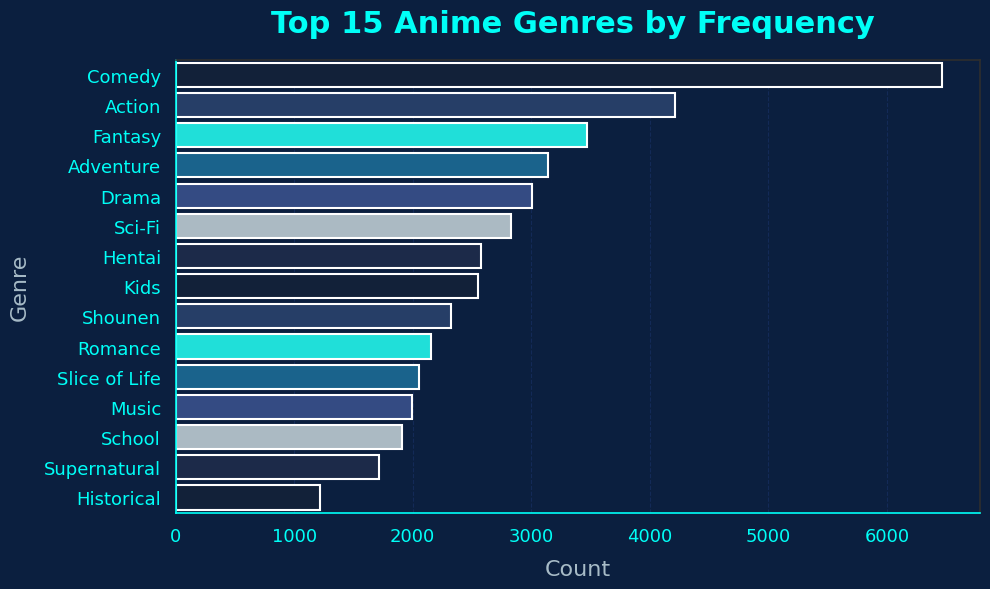

In [ ]:
#Bar Chart: Top Genres Frequency
genre_lists = animes_df['genre'].dropna().apply(eval).apply(lambda x: [g.strip() for g in x])
all_genres = [genre for sublist in genre_lists for genre in sublist]
genre_counts = pd.Series(all_genres).value_counts().head(15)

yugioh_palette =[
    "#0B1F3F",
    "#1B3B72",
    "#00FFF7",
    "#07689F",
    "#274690",
    "#A7BBC7",
    "#142850",
]

plt.figure(figsize=(10, 6))
sns.barplot(
    x=genre_counts.values,
    y=genre_counts.index,
    palette=yugioh_palette,
    edgecolor='white',
    linewidth=1.5
)

plt.title('Top 15 Anime Genres by Frequency ', fontsize=22, color="#00FFF7", pad=20, fontweight='bold')
plt.xlabel('Count', fontsize=16, color="#A7BBC7", labelpad=10)
plt.ylabel('Genre', fontsize=16, color="#A7BBC7", labelpad=10)
plt.grid(axis='x', alpha=0.3, linestyle='--', color="#274690")


plt.gca().set_facecolor("#0B1F3F")
plt.gcf().patch.set_facecolor("#0B1F3F")


plt.tick_params(colors='#00FFF7', labelsize=13, width=2, length=7)
plt.gca().spines['bottom'].set_color('#00FFF7')
plt.gca().spines['left'].set_color('#00FFF7')

plt.tight_layout()
plt.show()

/tmp/ipython-input-23-4114942512.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  boxplot = sns.boxplot(
/tmp/ipython-input-23-4114942512.py:24: UserWarning: 
The palette list has fewer values (7) than needed (15) and will cycle, which may produce an uninterpretable plot.
  boxplot = sns.boxplot(


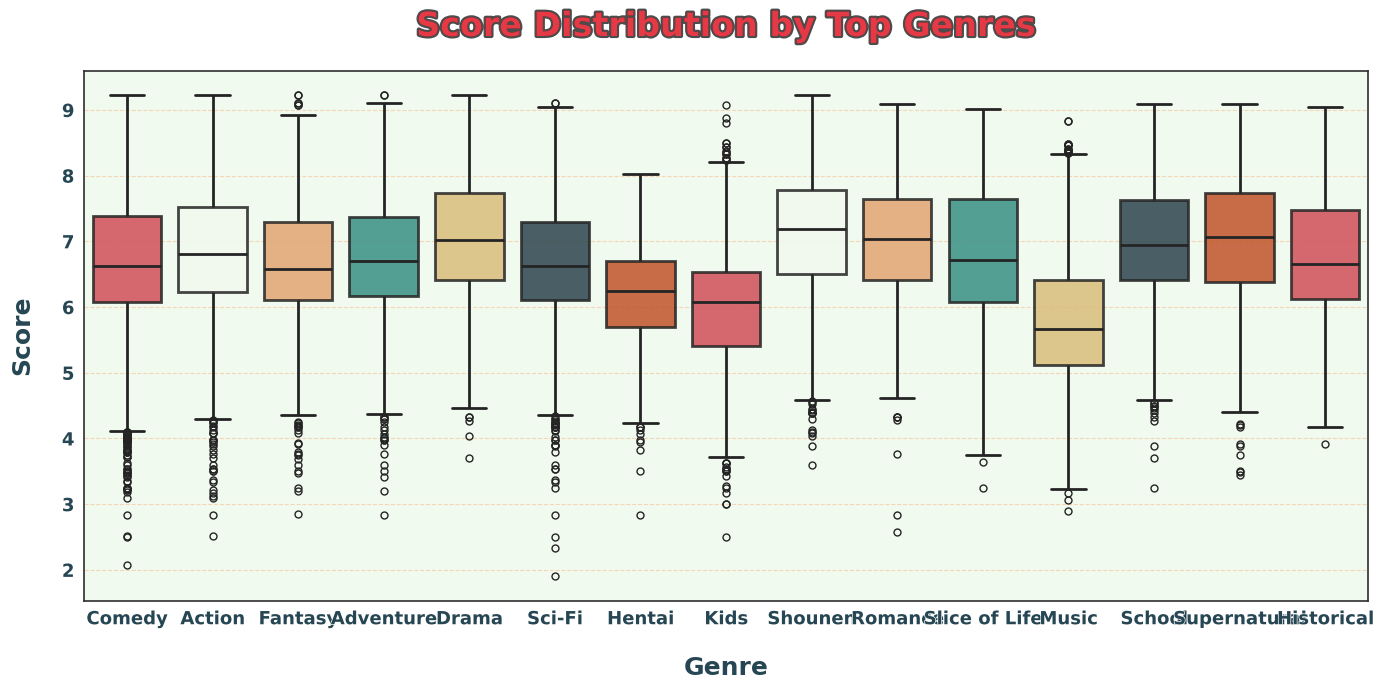

In [ ]:
# Box Plot: Score distribution by Top Genres
import matplotlib.patheffects as path_effects
top_genres = genre_counts.index.tolist()

df_expanded = animes_df[['score', 'genre']].copy()
df_expanded = df_expanded.dropna(subset=['score', 'genre'])
df_expanded['genre_list'] = df_expanded['genre'].apply(eval)
df_expanded = df_expanded.explode('genre_list')
df_expanded['genre_list'] = df_expanded['genre_list'].str.strip()

df_box = df_expanded[df_expanded['genre_list'].isin(top_genres)]

one_piece_palette = sns.color_palette([
    "#E63946",
    "#F1FAEE",
    "#F4A261",
    "#2A9D8F",
    "#E9C46A",
    "#264653",
    "#D9480F",
])

plt.figure(figsize=(14, 7))
boxplot = sns.boxplot(
    x='genre_list',
    y='score',
    data=df_box,
    order=top_genres,
    palette=one_piece_palette,
    linewidth=2,
    fliersize=5,
    boxprops=dict(alpha=0.85)
)

for patch in boxplot.artists:
    patch.set_edgecolor('#222222')
    patch.set_linewidth(1.8)
    patch.set_path_effects([
        path_effects.Stroke(linewidth=4, foreground='black', alpha=0.2),
        path_effects.Normal()
    ])

for label in boxplot.get_xticklabels() + boxplot.get_yticklabels():
    label.set_fontsize(13)
    label.set_fontweight('bold')
    label.set_color('#264653')
    label.set_path_effects([
        path_effects.Stroke(linewidth=1, foreground='white'),
        path_effects.Normal()
    ])


title = plt.title(
    'Score Distribution by Top Genres',
    fontsize=24, fontweight='bold', color='#E63946', pad=25
)
title.set_path_effects([
    path_effects.Stroke(linewidth=3, foreground='black', alpha=0.7),
    path_effects.Normal()
])

xlabel = plt.xlabel('Genre', fontsize=18, fontweight='bold', color='#264653', labelpad=20)
ylabel = plt.ylabel('Score', fontsize=18, fontweight='bold', color='#264653', labelpad=20)

plt.grid(axis='y', linestyle='--', alpha=0.4, color='#F4A261')


plt.gca().set_facecolor('#F1FAEE')

plt.tight_layout()
plt.show()